In [1]:
import os
import time
from hydra_zen import instantiate, make_config, builds, to_yaml, load_from_yaml, launch
import sys
import pickle

from pathlib import Path

import jax.numpy as np
from jax import vmap, random, grad, jit
import jax.numpy.linalg as lin
from functools import partial
from tqdm import tqdm

from grassgp.grassmann import valid_grass_point, sample_karcher_mean, grass_dist, grass_exp, valid_grass_tangent, grass_log, convert_to_projs, compute_barycenter
from grassgp.means import zero_mean
from grassgp.kernels import rbf
from grassgp.models_optimised import GrassGP
from grassgp.plot_utils import flatten_samples, plot_grass_dists
from grassgp.utils import to_dictconf, get_save_path, vec, unvec
from grassgp.utils import safe_save_jax_array_dict as safe_save
from grassgp.utils import load_and_convert_to_samples_dict as load_data

import chex
from chex import assert_shape, assert_rank
from dataclasses import dataclass, field
from typing import Tuple, Union, Callable, Tuple

import numpyro
from numpyro.infer import SVI, Trace_ELBO, autoguide, init_to_value
import numpyro.distributions as dist

from grassgp.inference import run_inference

import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def print_file(x: Path):
    with x.open("r") as f:
        print(f.read())

In [3]:
def pickle_save(obj, name: str):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

In [4]:
def pickle_load(name: str):
    with open(name, 'rb') as f:
        obj = pickle.load(f)
    return obj

# Load results and analyse

In [5]:
base_path = Path(os.getcwd())
output_folder = "multirun"
date = "2023-06-02"
time = "10-55-33"
id_num = "0"

In [6]:
job_path = base_path / output_folder / date / time / id_num
assert job_path.exists()

In [7]:
config = load_from_yaml(job_path / ".hydra" / "config.yaml")
overrides = load_from_yaml(job_path / ".hydra" / "overrides.yaml")

In [8]:
print("Overrides used for training:")
print(to_yaml(overrides))

Overrides used for training:
- model.ell=0.001
- model.cov_jitter=0.0001



In [9]:
dataset_path = job_path / "training_test_data.pickle"
assert dataset_path.exists()
training_test_data = pickle_load(dataset_path)

s_train = np.array(training_test_data['s_train'])
s_test = np.array(training_test_data['s_test'])

Ws_train = np.array(training_test_data['Ws_train'])
Ws_test = np.array(training_test_data['Ws_test'])

log_Ws_train = np.array(training_test_data['log_Ws_train'])
log_Ws_test = np.array(training_test_data['log_Ws_test'])

anchor_point = np.array(training_test_data['anchor_point'])

d, n = anchor_point.shape

In [10]:
try:
    os.makedirs(job_path / "images")
    print("Creating image directory in job path")
except FileExistsError:
    print("Directory already exists; skipping.")

Creating image directory in job path


In [13]:
def dataset_plot(s_train, s_test, Ws_train, Ws_test):
    W0 = Ws_test[0]
    # W0 = np.eye(100)[:,0][:,None]
    # W0 = rand_grass_point(random.PRNGKey(365),100,1)
    dists_test = vmap(lambda W: grass_dist(W, W0))(Ws_test)
    dists_train = vmap(lambda W: grass_dist(W, W0))(Ws_train)
    plt.plot(s_test,dists_test, label='test data')
    plt.scatter(s_train, dists_train, label='train data', c='r')
    plt.title(r"Grassmann distantance from $P(x_{0}^{*})$")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$d_{\operatorname{GR}}(P(x),P(x_{0}^{*}))$")
    plt.legend()
    plt.grid()
    plt.savefig(job_path / 'images/parametrised-ode-dataset-plot.pdf',dpi=300,bbox_inches='tight',facecolor="w")
    plt.show()

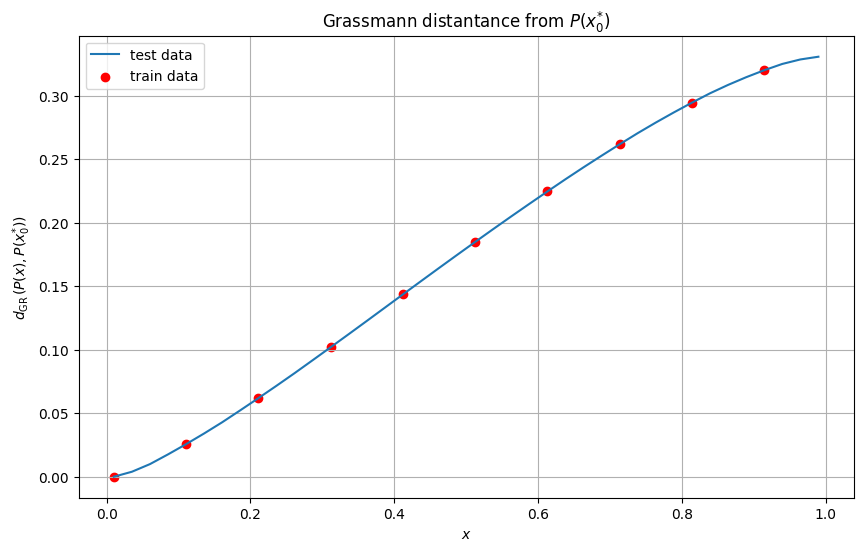

In [14]:
dataset_plot(s_train, s_test, Ws_train, Ws_test)

In [12]:
print_file(job_path / "hmc_log.txt")


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
 Omega_diag_chol[0]      0.92      0.60      0.79      0.05      1.81   1441.85      1.00
 Omega_diag_chol[1]      5.71      1.46      5.46      3.46      7.89    581.97      1.00
 Omega_diag_chol[2]      2.13      0.49      2.04      1.39      2.79    836.60      1.00
 Omega_diag_chol[3]      1.40      0.36      1.34      0.85      1.95    603.25      1.00
 Omega_diag_chol[4]      1.07      0.25      1.02      0.67      1.43    783.67      1.00
 Omega_diag_chol[5]      0.59      0.15      0.56      0.36      0.81    924.10      1.00
 Omega_diag_chol[6]      0.44      0.12      0.42      0.27      0.61   1274.86      1.00
 Omega_diag_chol[7]      0.28      0.08      0.27      0.16      0.40   1247.64      1.00
 Omega_diag_chol[8]      0.21      0.07      0.20      0.10      0.30    957.98      1.00
 Omega_diag_chol[9]      0.14      0.05      0.13      0.06      0.22   1641.50      1.00
Omega_dia

In [15]:
inference_data_path = job_path / "inference_data.pickle"
assert inference_data_path.exists()
inference_data = pickle_load(inference_data_path)
samples = dict(filter(lambda elem: 'initial_value' not in elem[0], inference_data.items()))
initial_values = dict(filter(lambda elem: 'initial_value' in elem[0], inference_data.items()))
assert set(samples.keys()).union(initial_values.keys()) == set(inference_data.keys())

In [16]:
def diagnostic_plots(cfg):
    my_samples = flatten_samples(samples, ignore=[])
    trace_plot_vars = [f"Omega_diag_chol[{i}]" for i in range(4)]
    trace_plot_vars.insert(0,'kernel_length')
    
    fig, axs = plt.subplots(5,2,figsize=(20,30))
    samples_filtered = my_samples[trace_plot_vars]
    name_map = {
        "kernel_length": r"$\ell$",
        "Omega_diag_chol[0]": r"$\omega_{1}$",
        "Omega_diag_chol[1]": r"$\omega_{2}$",
        "Omega_diag_chol[2]": r"$\omega_{3}$",
        "Omega_diag_chol[3]": r"$\omega_{4}$",
    }
    for (i,var) in enumerate(trace_plot_vars):
        var_name = name_map[var]
        axs[i,0].plot(samples_filtered[var],c='k')
        axs[i,0].set_xlabel(r"$n$")
        axs[i,0].grid()
        axs[i,0].set_title(f"Traceplot for {var_name}")
        sm.graphics.tsa.plot_acf(samples_filtered[var], lags=cfg.plots.acf_lags, ax=axs[i,1], title=f"Autocorrelation for {var_name}")
        axs[i,1].set_xlabel("lag")
        axs[i,1].grid()

    fig.savefig(job_path / 'images/parametrised-ode-diagnostic-plots.pdf',dpi=300,bbox_inches='tight',facecolor="w")
    plt.show()    

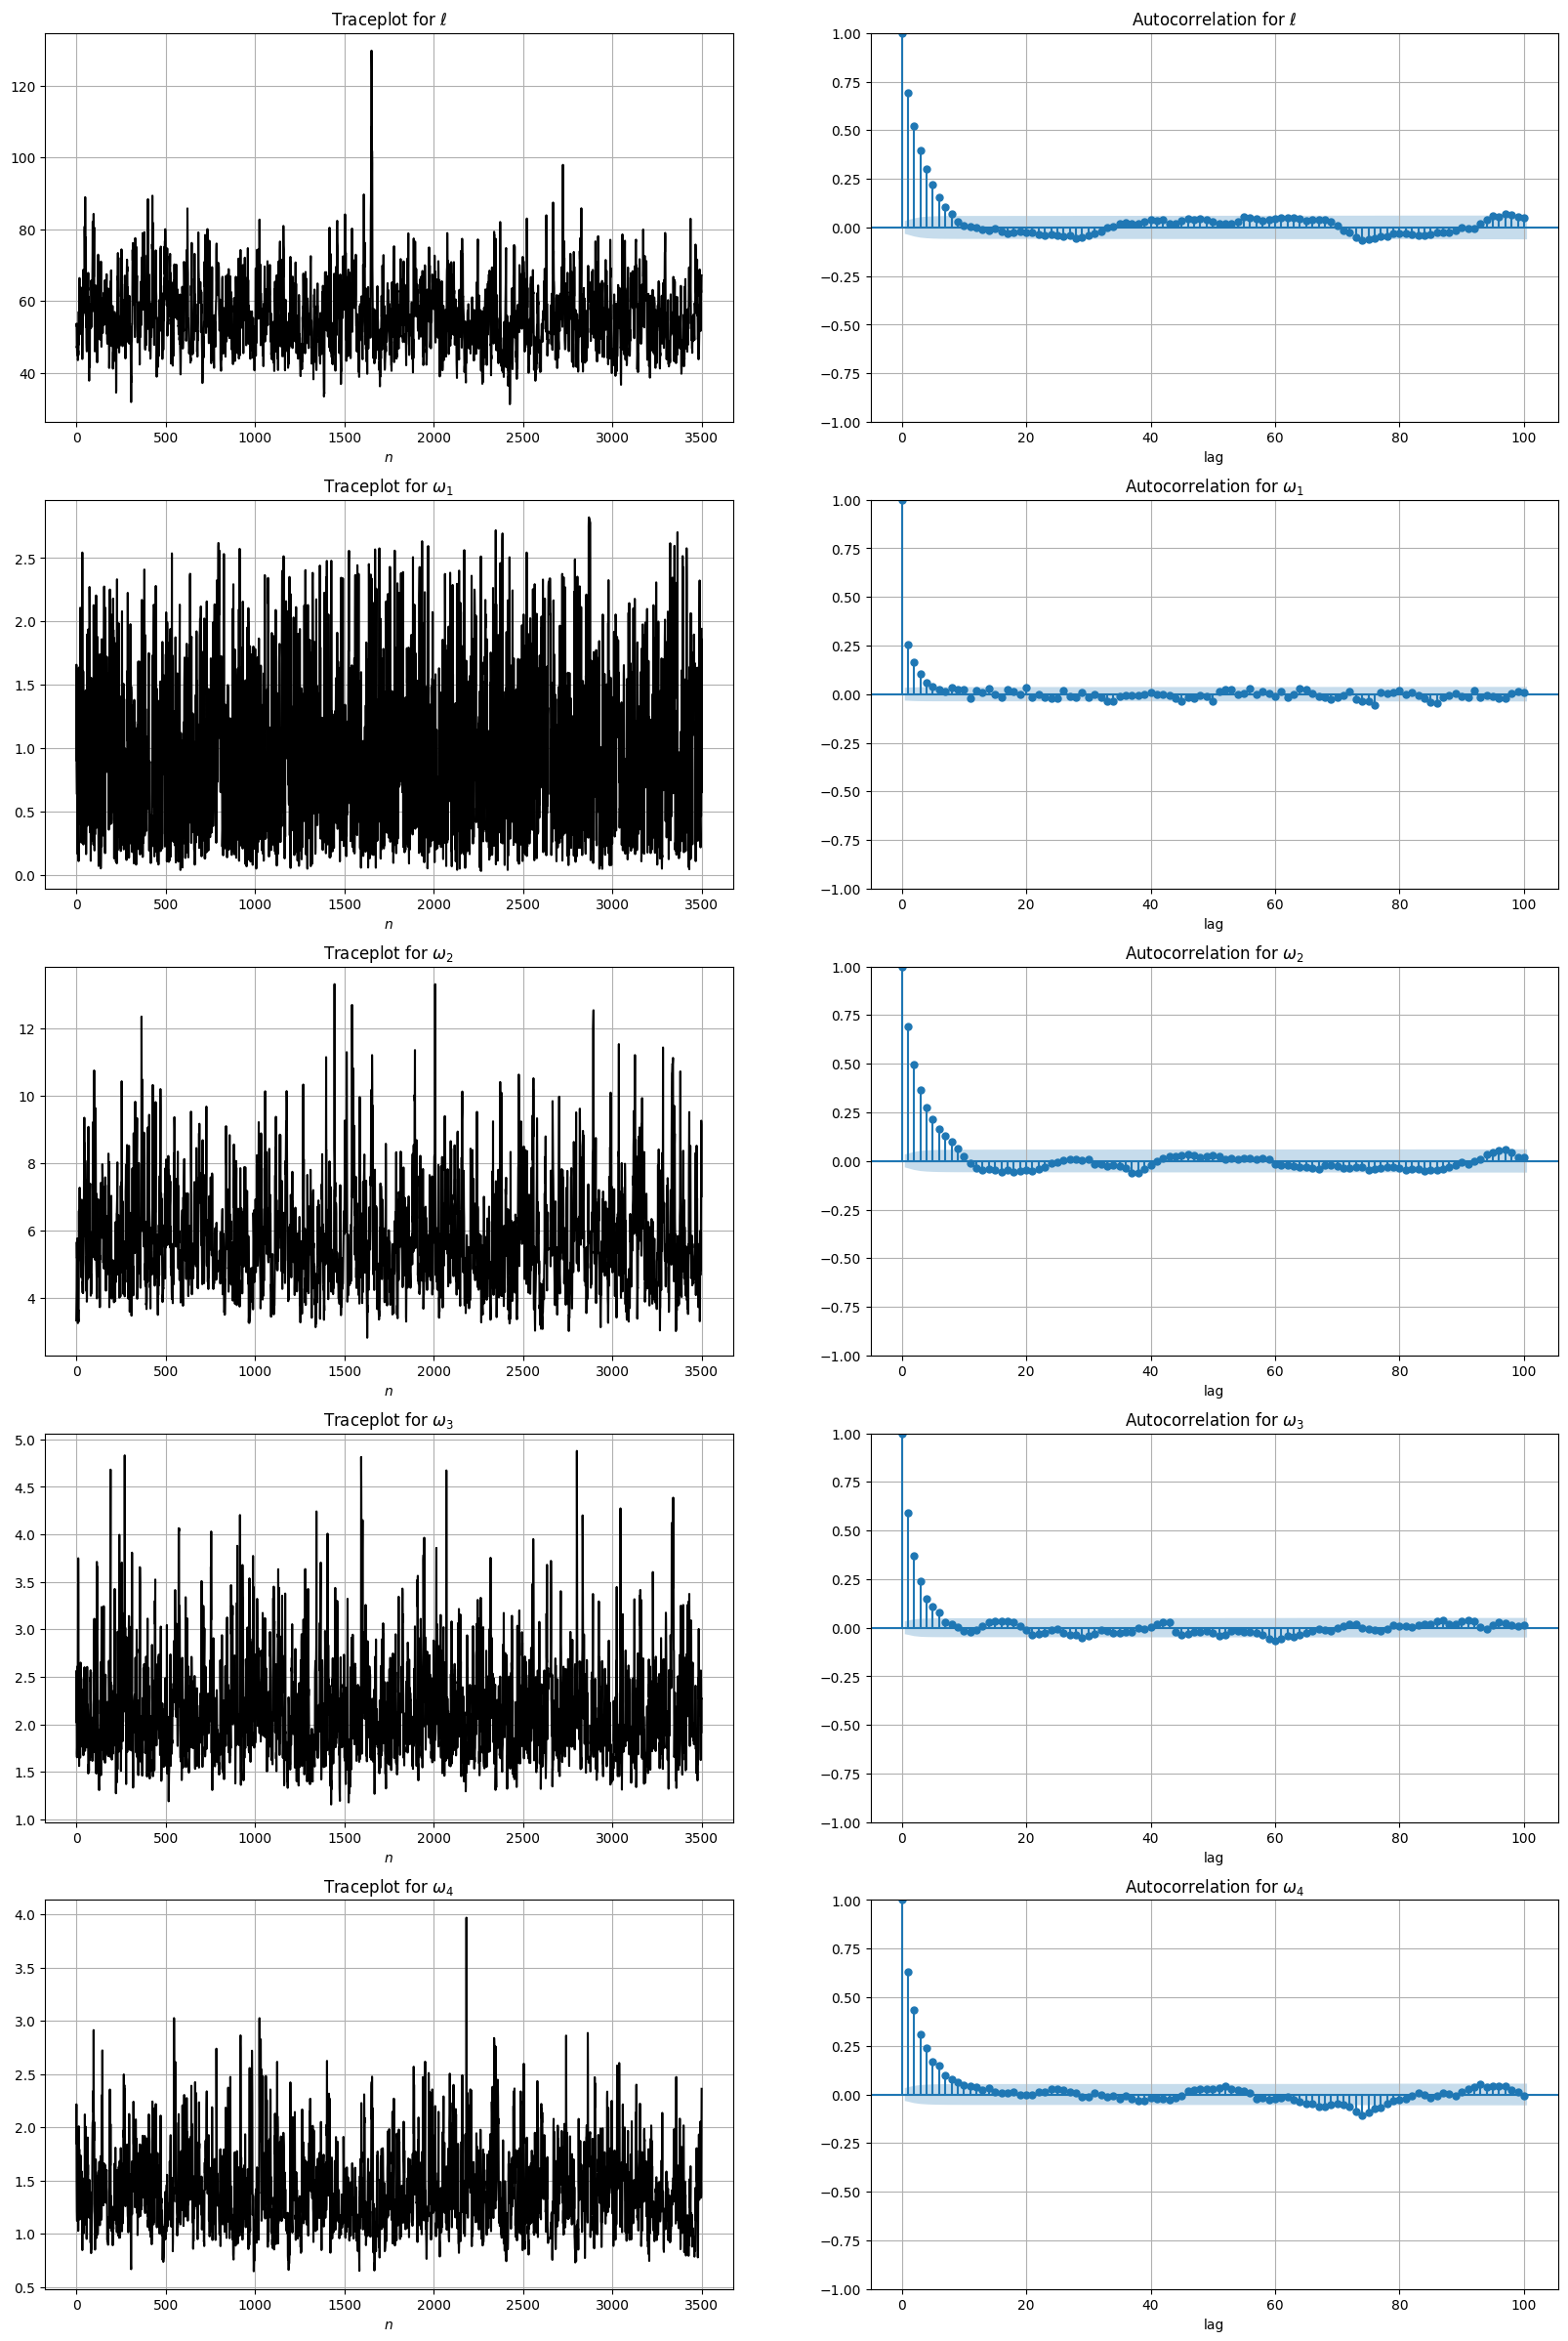

In [17]:
diagnostic_plots(config)

In [18]:
in_sample_errors_df = pickle_load(job_path / "in_sample_errors_df.pickle")
in_sample_errors_df.describe()

,s,errors,sd
count,10.000000,10.000000,10.000000
mean,0.462308,0.001124,0.006092
std,0.304318,0.001175,0.000195
min,0.010000,0.000401,0.005900
25%,0.236154,0.000493,0.005950
50%,0.462308,0.000711,0.006032
75%,0.688462,0.001068,0.006156
max,0.914615,0.004300,0.006496


In [19]:
out_sample_errors_df = pickle_load(job_path / "out_sample_errors_df.pickle")
out_sample_errors_df.describe()

,s,errors_mean,errors_pred,sd_mean,sd_pred
count,40.00000,40.000000,40.000000,40.000000,40.000000
mean,0.50000,0.026329,0.026338,0.000299,0.011020
std,0.29376,0.009333,0.009321,0.000133,0.000295
min,0.01000,0.014288,0.014143,0.000087,0.010565
25%,0.25500,0.018784,0.018884,0.000194,0.010831
50%,0.50000,0.025607,0.025556,0.000294,0.010926
75%,0.74500,0.030288,0.030296,0.000398,0.011211
max,0.99000,0.054694,0.054689,0.000565,0.011752


In [20]:
out_sample_mean_errors = out_sample_errors_df["errors_mean"]
out_sample_pred_errors = out_sample_errors_df["errors_pred"]
sd_s_test_means = out_sample_errors_df["sd_mean"]
sd_s_test_preds = out_sample_errors_df["sd_pred"]
upper_mean = out_sample_mean_errors + sd_s_test_means
upper_pred = out_sample_pred_errors + sd_s_test_preds

In [21]:
def error_plot(cfg):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    ax.plot(s_test,out_sample_mean_errors, c='k', alpha=0.75, label='error using means')
    ax.plot(s_test,out_sample_pred_errors, c='b', alpha=0.75, label='error using preds')
    # ax.plot(s_train,in_sample_errors_df['errors'], c='purple', alpha=0.75, label='in sample errors')
    ax.vlines(s_train, 0, 0.1, colors="green", linestyles="dashed")
    ax.fill_between(s_test, np.array(out_sample_pred_errors), np.array(upper_pred), color='lightblue', alpha=0.75, label=f'error + 1 std using means')
    ax.fill_between(s_test, np.array(out_sample_mean_errors), np.array(upper_mean), color='coral', alpha=0.75, label=f'error + 1 std using preds')
    ax.set_xlabel(r"$s$")
    ax.legend()
    ax.grid()
    ax.set_ylim((0.0,0.08))
    fig.savefig(job_path / 'images/out-sample-error-plot.png',dpi=300,bbox_inches='tight',facecolor="w")
    plt.show()

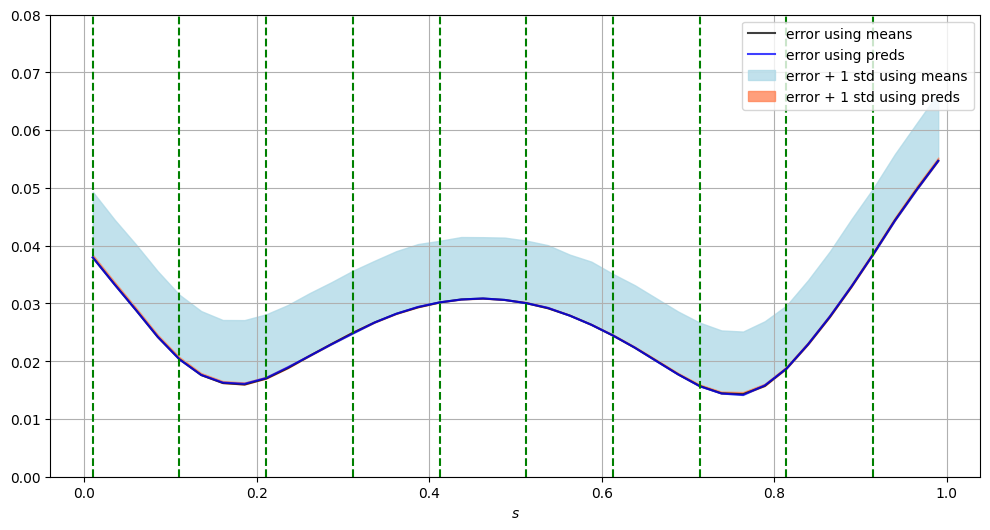

In [22]:
error_plot(config)